# Optimized Kalman Filter: A Tutorial

This notebook presents an explained demonstration of the Optimized Kalman Filter package (okf), using the guiding example of the Simple Lidar problem.

Familiarity with the Kalman Filter algorithm is assumed. We use the following notations for the KF model (where $\omega\sim N(0,Q)$ and $\nu\sim N(0,R)$):
$$ X_{t+1} = F\cdot X_t + \omega $$
$$ Z_{t} = H\cdot X_t + \nu $$

Contents:
* A minimal working example in one cell
* The Simple Lidar problem: an introduction
* Preparing the data
* Creating a model
* Training
* Testing & analysis

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import okf
from okf.example import simple_lidar_simulator as SIM
from okf.example import simple_lidar_model as LID

In [2]:
# Set wide notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))

# A minimal working example in one cell

After the minimal working example, we repeat all the steps below, explain them in detail, and demonstrate more features (e.g. analysis tools).

Note the format of the data needed for OKF train and test - 2 lists of n_targets each:
* X[i] = a numpy array of type double and shape (n_time_steps(target i), state_dimensions).
* Z[i] = a numpy array of type double and shape (n_time_steps(target i), observation_dimensions).

In [3]:
%%time

# Simulate data for the simple lidar example, and convert it to the required format
X, Z = SIM.simulate_data(fpath='data/simple_lidar_data.pkl')
X, Z = SIM.get_trainable_data(X, Z)
print('Data:')
print(f'Simulated states:\ta {type(X)} of {len(X):d} targets, each is a {type(X[0])} of shape (n_time_steps, {X[0].shape[1]}).')
print(f'Simulated observations:\ta {type(Z)} of {len(Z):d} targets, each is a {type(Z[0])} of shape (n_time_steps, {Z[0].shape[1]}).')

# Split to train/test data
n_train = int(0.7*len(X))
Ztrain, Xtrain = Z[:n_train], X[:n_train]
Ztest, Xtest = Z[n_train:], X[n_train:]

# Define model
lidar_model_args = dict(
    dim_x = 4,                                    # the number of entries in a state
    dim_z = 2,                                    # the number of entries in an observation
    init_z2x = LID.initial_observation_to_state,  # a function that receives the first observation and returns the first state-estimate
    F = LID.get_F(),                              # the dynamics model: a pytorch tensor of type double and shape (dim_x, dim_x)
    H = LID.get_H(),                              # the observation model: a pytorch tensor of type double and shape (dim_z, dim_x); or a function (see below)
    loss_fun = LID.loss_fun(),                    # function(predicted_x, true_x) used as loss for training and evaluation
    model_files_path = 'models',                  # directory in which to save the model
)
print('---------------\nModel arguments:\n', lidar_model_args)
baseline_model = okf.OKF(**lidar_model_args, optimize=False, model_name='KF')
model = okf.OKF(**lidar_model_args)

# Train
okf.train(baseline_model, Ztrain, Xtrain)
print('---------------\nBaseline KF model training (noise estimation) done.')
okf.train(model, Ztrain, Xtrain, verbose=1)

# Test
print('---------------\nTest loss:')
baseline_loss = okf.test_model(baseline_model, Ztest, Xtest, loss_fun=LID.loss_fun())
loss = okf.test_model(model, Ztest, Xtest, loss_fun=LID.loss_fun())
print(f'KF (baseline):\t{baseline_loss:.0f}')
print(f'OKF:\t{loss:.0f}')
print('---------------')

Data:
Simulated states:	a <class 'list'> of 1000 targets, each is a <class 'numpy.ndarray'> of shape (n_time_steps, 4).
Simulated observations:	a <class 'list'> of 1000 targets, each is a <class 'numpy.ndarray'> of shape (n_time_steps, 2).
---------------
Model arguments:
 {'dim_x': 4, 'dim_z': 2, 'init_z2x': <function initial_observation_to_state at 0x000001C615C1C598>, 'F': tensor([[1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64), 'H': tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.]], dtype=torch.float64), 'loss_fun': <function loss_fun.<locals>.<lambda> at 0x000001C615C381E0>, 'model_files_path': 'models'}
---------------
Baseline KF model training (noise estimation) done.

Training OKF:
samples=595(t)+105(v)=700; batch_size=10; iterations=1(e)x59(b)=59.
[OKF] Training done (29 [s])
	best valid loss: 767;	no early stopping:	1 epochs, 59 batches, 59 total iterations.
---------------
Test loss:
KF (baseline):	808


----------
----------
----------

# The Simple Lidar problem: an introduction

Our example problem is a simulation of a simple lidar system: there is a single lidar sensor in a constant, known location, and we iteratively receive new measurements of the target location from the sensor.

Our simulator generates the data as 2 lists of dataframes:
* X[i] = a dataframe of the i'th target states.
* Z[i] = a dataframe of the i'th target observations.

In [4]:
# True = load existing data; False = generate new data (takes a few seconds)
ONLY_LOAD = False

In [5]:
%%time

if ONLY_LOAD:
    X, Z = SIM.load_data(fpath='data/simple_lidar_data.pkl')
else:
    X, Z = SIM.simulate_data(fpath='data/simple_lidar_data.pkl')

print(f'Simulated states:\ta {type(X)} of {len(X):d} targets, each is a {type(X[0])} of shape (n_time_steps, {X[0].shape[1]}).')
print(f'Simulated observations:\ta {type(Z)} of {len(Z):d} targets, each is a {type(Z[0])} of shape (n_time_steps, {Z[0].shape[1]}).')

Simulated states:	a <class 'list'> of 1000 targets, each is a <class 'pandas.core.frame.DataFrame'> of shape (n_time_steps, 4).
Simulated observations:	a <class 'list'> of 1000 targets, each is a <class 'pandas.core.frame.DataFrame'> of shape (n_time_steps, 2).
Wall time: 2.67 s


In [6]:
X[0].head()

,x,y,vx,vy
0,298.624903,212.204014,-32.842848,-57.433118
1,268.034428,155.509038,-28.338102,-55.956834
2,241.908411,100.403508,-23.913932,-54.254227
3,220.157759,47.117916,-19.587371,-52.316956
4,202.675067,-4.108919,-15.378013,-50.136714


In [7]:
Z[0].head()

,zx,zy
0,300.191065,216.954926
1,271.823240,149.315328
2,246.500645,96.774684
3,219.699965,52.872646
4,204.150537,-1.619252


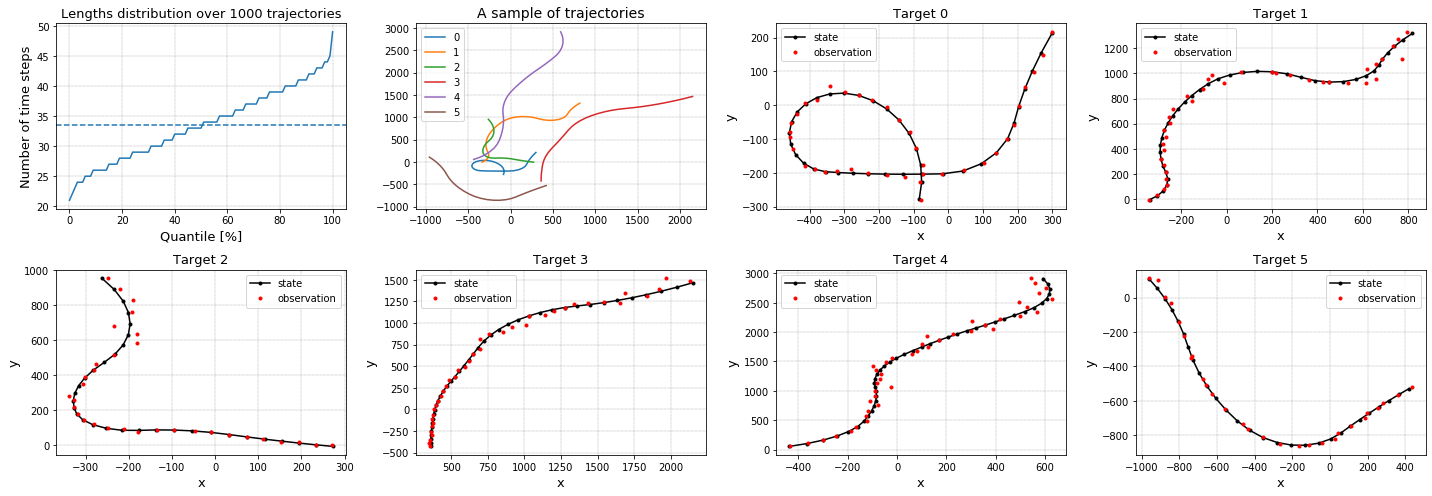

In [8]:
SIM.display_data(X, Z);

# Prepare the data

The data format used in the okf package is 2 lists of n_targets:
* X[i] = a numpy array of type double and shape (n_time_steps(target i), **state_dimensions**).
* Z[i] = a numpy array of type double and shape (n_time_steps(target i), **observation_dimensions**).

In our example, we just need to convert the dataframes into numpy arrays, as implemented in the simulator module:

In [9]:
X, Z = SIM.get_trainable_data(X, Z)

print(f'Simulated states:\ta {type(X)} of {len(X):d} targets, each is a {type(X[0])} of shape (n_time_steps, {X[0].shape[1]}).')
print(f'Simulated observations:\ta {type(Z)} of {len(Z):d} targets, each is a {type(Z[0])} of shape (n_time_steps, {Z[0].shape[1]}).')

Simulated states:	a <class 'list'> of 1000 targets, each is a <class 'numpy.ndarray'> of shape (n_time_steps, 4).
Simulated observations:	a <class 'list'> of 1000 targets, each is a <class 'numpy.ndarray'> of shape (n_time_steps, 2).


In [10]:
print(len(X))
X[0][:5, :]

1000


array([[298.62490312, 212.20401444, -32.8428479 , -57.43311845],
       [268.03442807, 155.50903824, -28.33810219, -55.95683395],
       [241.9084109 , 100.40350764, -23.91393217, -54.25422726],
       [220.15775918,  47.1179161 , -19.58737127, -52.31695581],
       [202.67506706,  -4.10891902, -15.37801296, -50.13671443]])

In [11]:
print(len(Z))
Z[0][:5, :]

1000


array([[300.19106466, 216.95492596],
       [271.82324048, 149.31532829],
       [246.50064459,  96.77468422],
       [219.69996548,  52.87264646],
       [204.15053727,  -1.6192523 ]])

### Split to train/test data

Note that in the terminology of machine learning, Z is the sequential input and X is the sequential output.

In [12]:
n_train = int(0.7*len(X))

Ztrain, Xtrain = Z[:n_train], X[:n_train]
Ztest, Xtest = Z[n_train:], X[n_train:]

# Model

### Prepare the model configuration

To create a model, we need to define the state & observation dimensions; the dynamics & observation models; and the function that initializes the state according to the first observation in a new trajectory.
All these are provided by the `okf.example.simple_lidar_model.py` module:

In [13]:
lidar_model_args = dict(
    dim_x = 4,                                    # the number of entries in a state
    dim_z = 2,                                    # the number of entries in an observation
    init_z2x = LID.initial_observation_to_state,  # a function that receives the first observation and returns the first state-estimate
    F = LID.get_F(),                              # the dynamics model: a pytorch tensor of type double and shape (dim_x, dim_x)
    H = LID.get_H(),                              # the observation model: a pytorch tensor of type double and shape (dim_z, dim_x); or a function (see below)
    loss_fun=LID.loss_fun(),                      # function(predicted_x, true_x) used as loss for training and evaluation
    model_files_path = 'models',                       # directory in which to save the model
)

print('Dynamics model (F) & observation model (H):')
lidar_model_args['F'], lidar_model_args['H']

Dynamics model (F) & observation model (H):


(tensor([[1., 0., 1., 0.],
         [0., 1., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=torch.float64),
 tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.]], dtype=torch.float64))

### Create the models

In this example, we will train and test the following models:
1. **KF**: A standard KF tuned by noise estimation.
2. **OKF**: A KF optimized wrt the MSE of the location estimates.

In [14]:
models = [
    okf.OKF(model_name='KF',  optimize=False, **lidar_model_args),
    okf.OKF(model_name='OKF', optimize=True,  **lidar_model_args),
]

#### Handling a non-linear model (not needed in our example)

**Q**: What if the model is not linear, i.e., F or H is not a constant matrix?

**A**: okf supports a non-linear models - you simply need to provide a function instead of a matrix.

For example, if the sensor is a 2D Doppler radar, and you want to use the recent observation to approximate the non-linear observation model, you have to pass the following `H` to OKF:

def H(x, z):
    # :param x: the current state estimate (unused in this case; could be used instead of z to approximate H).
    # :param z: the current observation.
    # The resulting observation model is a linear transformation (3x4 matrix): x,y,vx,vy -> x,y,Doppler.
    r = np.sqrt(z[0]**2+z[1]**2)
    return torch.tensor([
        [1, 0,      0,      0],
        [0, 1,      0,      0],
        [0, 0, z[0]/r, z[1]/r],
    ], dtype=torch.double)


# Train

We can call `okf.train()` for every model or `okf.train_models()` once for all models:

In [15]:
%%time
res_per_iter, res_per_sample = okf.train_models(models, Ztrain, Xtrain, verbose=2)


Training OKF:
samples=595(t)+105(v)=700; batch_size=10; iterations=1(e)x59(b)=59.
	[OKF] 01.0001/01.0059:	train_RMSE=28.61, valid_RMSE=26.45   |   2 [s]
	[OKF] 01.0031/01.0059:	train_RMSE=26.47, valid_RMSE=24.44   |   16 [s]
	[OKF] 01.0059/01.0059:	train_RMSE=25.44, valid_RMSE=23.99   |   28 [s]
[OKF] Epoch 1/1 (28 [s])
[OKF] Training done (28 [s])
	best valid loss: 598;	no early stopping:	1 epochs, 59 batches, 59 total iterations.
Wall time: 31.5 s


Only optimized models appear in the training monitor, but all models appear in the final results:

In [16]:
print('Models in training monitor:')
print(print(np.unique(res_per_iter.model)))
res_per_iter.head()

Models in training monitor:
['OKF']
None


,model,t,group,loss,RMSE
0,OKF,1,train,818.554871,28.610398
1,OKF,2,train,812.876863,28.510995
2,OKF,3,train,860.398226,29.332546
3,OKF,4,train,748.919548,27.366394
4,OKF,5,train,631.230012,25.124291


In [17]:
print('Models in final results:')
print(print(np.unique(res_per_sample.model)))
res_per_sample.head()

Models in final results:
['KF' 'OKF']
None


,model,target,t,SE,AE,loss
0,KF,0,0,96.346271,9.815614,96.346271
1,KF,0,1,88.521987,9.408612,88.521987
2,KF,0,2,53.120945,7.288412,53.120945
3,KF,0,3,15.758871,3.969744,15.758871
4,KF,0,4,3.365195,1.834447,3.365195


OKF training summary:

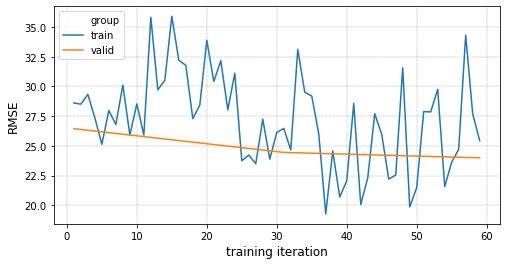

In [18]:
ax = okf.utils.Axes(1, 1, axsize=(8,4))[0]
sns.lineplot(data=res_per_iter[res_per_iter.model=='OKF'], x='t', hue='group', y='RMSE', ax=ax)
okf.utils.labels(ax, 'training iteration', 'RMSE');

### Parameters inspection

We can display the learned parameters Q,R.

In our example, we see that the optimization learned to decrease the parameters of the observation noise R: the values in the bottom-right heatmap are lower than in the top-right.

In our paper, we explain how this is caused by the choice of coordinates, which makes the noise autocorrelated.
This issue is easy to miss, and without using the optimizer, the user might not even be aware to the sub-optimality of the model.

<Figure size 432x288 with 0 Axes>

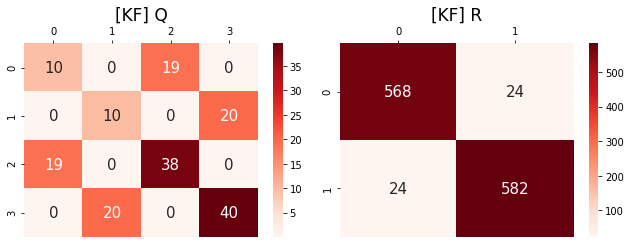

<Figure size 432x288 with 0 Axes>

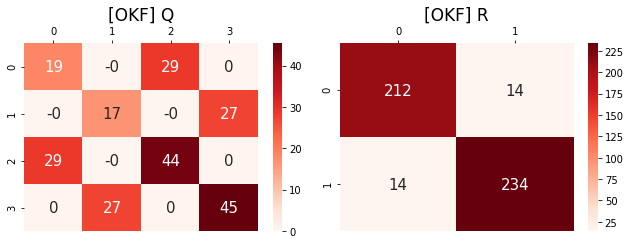

In [19]:
for m in models:
    plt.figure()
    m.display_params()

# Test

In [20]:
# Reloading the models is not necessary if run the tests immediately after training
for m in models:
    m.load_model()

Test every model over all the test data, and concatenate all the results to a single data-frame:

In [21]:
%%time
test_res = pd.DataFrame()
for m in models:
    test_res = pd.concat((test_res, okf.test_model(m, Ztest, Xtest, detailed=True, loss_fun=LID.loss_fun())))
test_res.head()

Wall time: 9.88 s


,model,target,t,SE,AE,loss
0,KF,0,0,323.304639,17.980674,323.304639
1,KF,0,1,496.381740,22.279626,496.381740
2,KF,0,2,277.359022,16.654099,277.359022
3,KF,0,3,85.864773,9.266325,85.864773
4,KF,0,4,30.757154,5.545913,30.757154


Various visualizations are supported.

In our example, it is clear that the optimization achieves significantly more accurate state estimations than noise estimation (lower filtering errors).

Wall time: 2.95 s


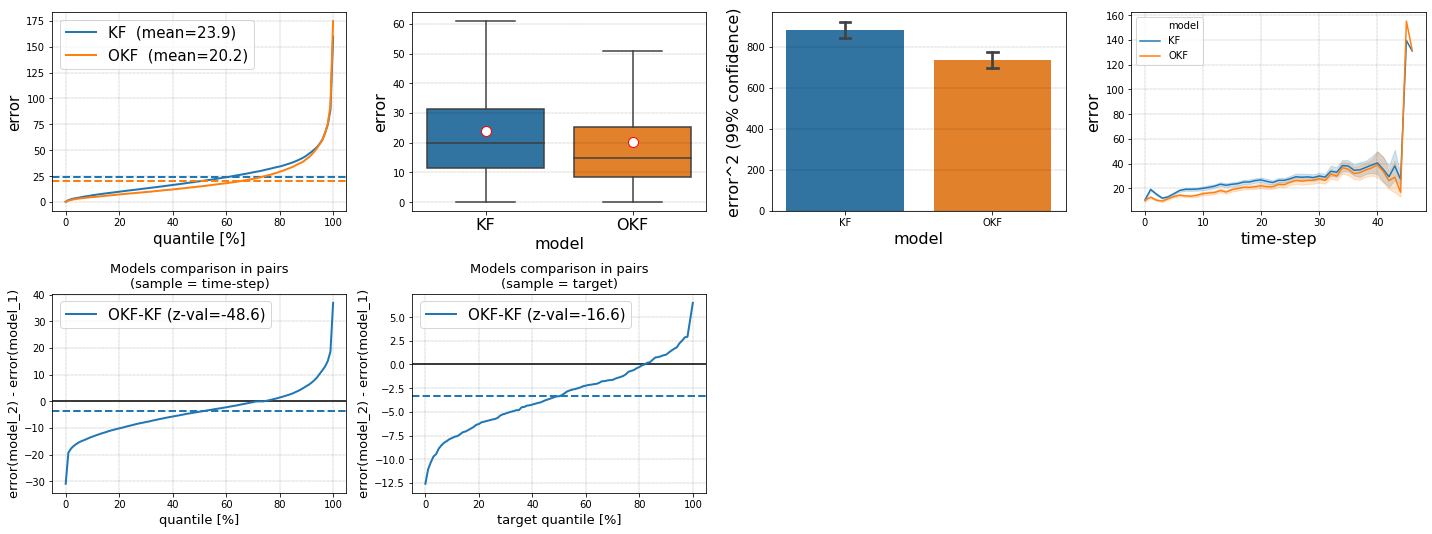

In [22]:
%%time
okf.analyze_test_results(test_res);

#### Tracking visualization

Note that in our example problem, the targets begin relatively close to the sensor and their distance tends to grow in time. Thus, the observation errors, which are simulated i.i.d in polar coordinates, tend to increase in Cartesin coordinates. This also explains the figure above of the error vs. time-step.

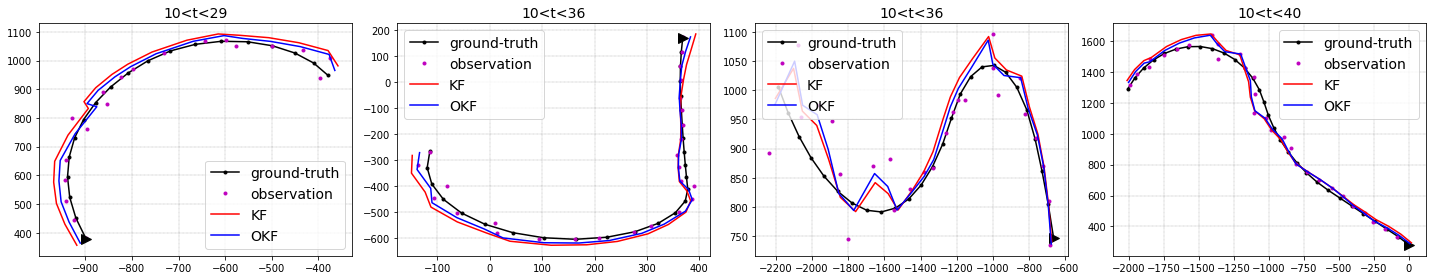

In [23]:
# Note:
#   - (xdim, ydim) determine which state-dimensions to plot - in our case the (x,y) location components.
#   - show_observations=True shows observations in addition to states, using the same (xdim, ydim).
okf.display_tracking(models, Ztest, Xtest, n=4, t_min=10, xdim=0, ydim=1, show_observations=True);